In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from matplotlib import pyplot as plt
import numpy as np
import copy
import math

In [2]:
pd.options.display.max_columns = 25

In [3]:
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact

In [4]:
def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

In [5]:
# ----- READ IN DATA -----
df = pd.read_csv('subscriber_data.csv')
df_train, df_test = model_selection.train_test_split(df, test_size=0.3, random_state=100)

In [6]:
# ----- FIT CHURN MODEL ------
y_col_name = 'churn_TF' # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
x_col_name = ['age', 'income', 'hours', 'female']    # list of x covariates
add_constant_TF = True

In [7]:
# --- preprocess data for model routine format requirements
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

In [8]:
# --- fit linear probability model
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:               churn_TF   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     235.6
Date:                Wed, 08 Dec 2021   Prob (F-statistic):          4.63e-190
Time:                        16:06:27   Log-Likelihood:                -4565.8
No. Observations:                7000   AIC:                             9142.
Df Residuals:                    6995   BIC:                             9176.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.12

In [9]:
# --- fit logistic regression
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.619667
         Iterations 5

RESULTS OF LOGIT MODEL FITTING

                           Logit Regression Results                           
Dep. Variable:               churn_TF   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6995
Method:                           MLE   Df Model:                            4
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:                 0.09255
Time:                        16:06:27   Log-Likelihood:                -4337.7
converged:                       True   LL-Null:                       -4780.1
Covariance Type:            nonrobust   LLR p-value:                3.284e-190
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.5915      0.028     21.395      0.000       0.537       0.

In [10]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

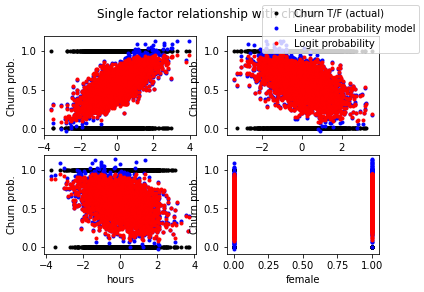

In [11]:
# plot predictions vs. data
select_plot_coef = [x for x in x_col_name if x != 'const']
n_rows = 2
n_cols = math.ceil(len(select_plot_coef) / n_rows)
fig, axes = plt.subplots(n_rows, n_cols)
fig.suptitle('Single factor relationship with churn')
for i in range(n_rows):
    for j in range(n_cols):
        select_coef = select_plot_coef[i * n_cols + j]
        axes[i, j].plot(df_test[select_coef], df_test['churn_TF'], 'k.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_lpm'], 'b.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_logit'], 'r.')
        axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

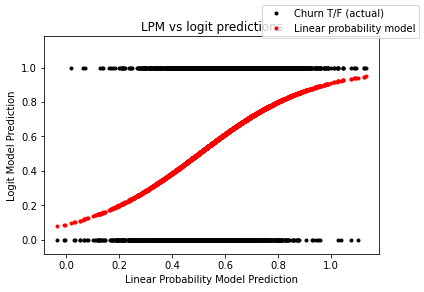

In [12]:
# compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(df_test[['prob_churn_lpm']], df_test[['churn_TF']], 'k.')
ax.plot(df_test[['prob_churn_lpm']], df_test[['prob_churn_logit']], 'r.')
plt.ylim(df_test[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.05, df_test[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.05)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

In [13]:
# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_lpm'])

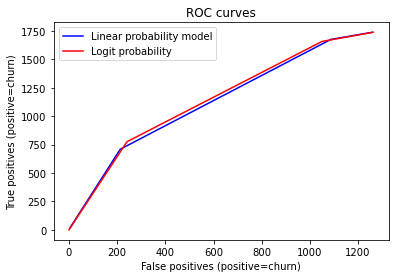

In [14]:
# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-')
ax1.plot(logit_false_positives, logit_true_positives, 'r-')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Q1

In [15]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

In [16]:
# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
np.random.seed(0)
df_test['random_draws'] = np.random.random(df_test.shape[0])

In [17]:
# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

In [18]:
df_impact

,subs,revenue,lift_from_no_offer
no_offer,1263,12630,0.0
lpm_offer,1655,13421,0.062629
logit_offer,1654,13435,0.063737


# Q2

In [19]:
# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

In [20]:
df_lift_threshold[(df_lift_threshold['logit_offer'] == max(df_lift_threshold['logit_offer']))]

,threshold,no_offer,lpm_offer,logit_offer
61,0.61,0.0,0.07981,0.081235


In [21]:
df_test_2, df_impact_2 = apply_offers(df_test, 0.61, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

In [22]:
df_impact_2

,subs,revenue,lift_from_no_offer
no_offer,1263,12630,0.0
lpm_offer,1539,13638,0.07981
logit_offer,1554,13656,0.081235


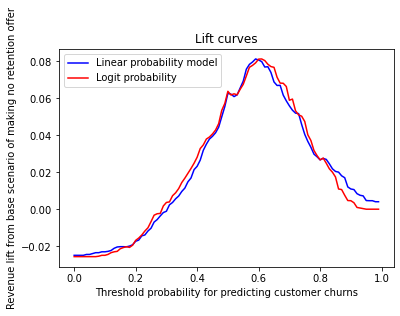

In [23]:
# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Q3

In [24]:
# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100

    _, t_df_impact = apply_offers(df_test, 0.61, base_price, t_discount_amount, cases, t_discount_amount, acceptance_rate_nonchurn )

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

In [25]:
df_lift_discount_amount[(df_lift_discount_amount['logit_offer'] == max(df_lift_discount_amount['logit_offer']))]

,discount_amount,no_offer,lpm_offer,logit_offer
34,0.34,0.0,0.085352,0.086429


In [26]:
df_test_3, df_impact_3 = apply_offers(df_test, 0.61, base_price, 0.34, cases, 0.34, acceptance_rate_nonchurn)

In [27]:
df_impact_3

,subs,revenue,lift_from_no_offer
no_offer,1263,12630,0.0
lpm_offer,1585,13708.0,0.085352
logit_offer,1602,13721.6,0.086429


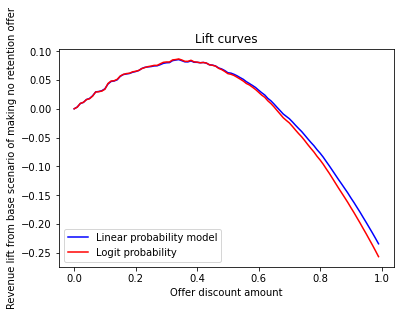

In [28]:
# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Q4

In [29]:
# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    t_discount_amount = t_ind/100
    _, t_df_impact = apply_offers(df_test, 0.61, base_price, t_discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

In [30]:
df_lift_acceptance_rate_churn[(df_lift_acceptance_rate_churn['logit_offer'] == max(df_lift_acceptance_rate_churn['logit_offer']))]

,acceptance_rate_churn,no_offer,lpm_offer,logit_offer
34,0.34,0.0,0.085352,0.086429


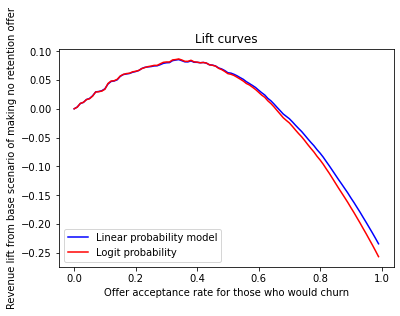

In [31]:
# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])